[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/WilliamLockeIV/Spline-Theory-and-Neural-Collapse/blob/main/Theory/Background_on_Spline_Theory.ipynb)

# Setup

In [1]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchvision.transforms import v2
from torchvision.datasets import MNIST
from sklearn.datasets import make_moons

In [2]:
transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.1307], std=[0.3081])
])

# Load Datasets into /content
mnist = MNIST('/content', train=True, download=True, transform=transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.29MB/s]


## Functions

In [ ]:
# Define functions to find model activations, partitions, and complexity

def get_activations(model, name):
    '''
    params:
        name (string): Name of layer to store activations

    returns:
        None, writes activations to model dictionary "activations"
    '''
    def hook(module, input, output):
        model.activations[name] = output.detach().clone()
    return hook


def get_partitions(model, x_span, y_span):
    '''
    params:
        x_span (tuple): Tuple of the form (x_min, x_max, x_samples) indicating the minimum and maximum x-values
                        over which to calculate partitions and the number of samples within that range.
        y_span (tuple): Tuple of the form (y_min, y_max, y_samples), same purpose as for x_span but for y-dimension.

    returns:
        partitions (dict): Dictionary of {layer:vertices} storing vertices that can be used to graph the partitions
                           drawn by each layer's neurons.
    '''
    model.activations = dict()
    partitions = dict()
    x_span = np.linspace(*x_span)
    y_span = np.linspace(*y_span)
    meshgrid = np.meshgrid(x_span, y_span)
    uniform_input = torch.tensor(np.stack([meshgrid[0].reshape(-1), meshgrid[1].reshape(-1)], 1), dtype=torch.float32)
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d):
            hooks.append(module.register_forward_hook(get_activations(model, name)))
    with torch.no_grad():
        model.forward(uniform_input)
    for hook in hooks:
        hook.remove()
    for layer, activation in model.activations.items():
        paths = [plt.contour(
            meshgrid[0], meshgrid[1], activation[:,i].reshape(meshgrid[0].shape), [0]
        ) for i in range(activation.shape[1])]
        paths = [path.get_paths()[0] for path in paths]
        plt.close()
        paths = [path.vertices[:-1] for path in paths]
        partitions[layer] = paths

    return partitions


def get_local_complexity(model, dl, radius=0.015, dim=None, seed=None, log=False):
    '''
    Measure local complexity and eccentricity; optionally update model log.

    params:
        dl (DataLoader):  Dataloader over which to calculate local complexity
        radius (float):   Radius of convex neighborhood around inputs in which to calculate local
                          complexity. Smaller values tend to be deformed less by deep networks.
        dim (int):        Number of dimensions of convex neighborhood. If None, will default to
                          number of input dimensions.
        seed (int):       The orthogonal hulls around datapoints are oriented randomly. Set an integer
                          seed for reproducibility between function calls. If dim=1, orientation is
                          always the same regardless of seed or lack thereof.
        log (bool):       If True, update model.log with total local complexity.

    returns:
        local_complexity (dict): Nested dictionary of {layer: {Complexity:float, Eccentricity:float}},
                                along with a final key of {Total: {Complexity:float, Eccentricity:float}}
                                for the entire model.
    '''
    model.activations = dict()
    hooks = []
    samples = 0
    local_complexity = dict()
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d):
            hooks.append(module.register_forward_hook(get_activations(model, name)))
            local_complexity[name] = {'Complexity':0, 'Eccentricity':0}

    if seed is not None:
        torch.manual_seed(seed)

    with torch.no_grad():
        for batch in dl:
            image, class_labels = batch
            samples += len(class_labels)
            image_dim = np.prod(image.shape[1:])
            if dim is None or dim > image_dim:
                dim = image_dim
            rand = torch.rand((image_dim, dim))
            ortho, _ = torch.linalg.qr(rand)
            ortho = ortho.reshape((dim, *image.shape[1:]))
            ortho = ortho * radius
            ortho_hulls = torch.cat([image[:,None], image[:,None] + ortho, image[:,None] - ortho], dim=1)
            input_hulls = ortho_hulls.reshape(ortho_hulls.shape[0] * ortho_hulls.shape[1], *ortho_hulls.shape[2:])
            _ = model.forward(input_hulls)

            for layer, activation in model.activations.items():
                activation = activation.reshape(ortho_hulls.shape[0], ortho_hulls.shape[1], -1)
                eccentricity = torch.cdist(activation, activation).amax(dim=(1,2)).sum()
                signs = torch.sign(activation)
                complexity = (signs[:,1:] != signs[:,:1]).any(dim=1).sum()
                local_complexity[layer]['Complexity'] += complexity.item()
                local_complexity[layer]['Eccentricity'] += eccentricity.item()

    for hook in hooks:
        hook.remove()

    for layer, dictionary in local_complexity.items():
        for key in dictionary.keys():
            local_complexity[layer][key] /= samples

    total_complexity = sum([local_complexity[layer]['Complexity'] for layer in local_complexity.keys()])
    max_eccentricity = max([local_complexity[layer]['Eccentricity'] for layer in local_complexity.keys()])
    local_complexity['Total'] = {'Complexity':total_complexity, 'Eccentricity':max_eccentricity}

    if log is True:
        model.log['Local Complexity'].append(local_complexity['Total']['Complexity'])
        model.log['Eccentricity'].append(local_complexity['Total']['Eccentricity'])

    return local_complexity

# Spline Theory of Deep Networks

"A Spline Theory of Deep Networks" was written by Randall Balestriero and Richard Baraniuk (2018a, 2018b) and expanded upon in subsequent papers. Two key insights of this theory are:

1.   Many deep neural networks (DNs) can be modeled as a composition of max-affine spline operators (MASOs); and
2.   These MASO DNs partition their input space into disjoint regions, where the transformation from input to output is a *simple affine transformation* specific to each region.

## 1D Shallow Network

To illustrate this, we'll start with a simple, shallow network. This example is recreated from Simon Prince's book, "Understanding Deep Learning" (2023, chapter 3), which also has an [interactive figure](https://udlbook.github.io/udlfigures/) you can experiment with (3.3a 1D shallow network).

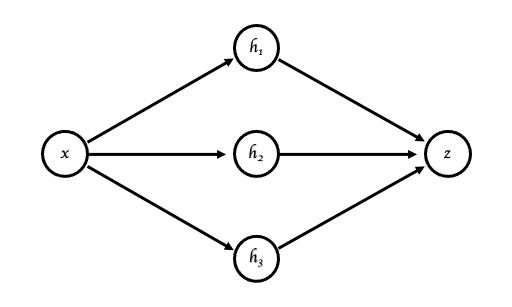

This simple DN has a 1-dimensional input, a single hidden layer with 3 neurons, and a 1-dimensional output. We start by visualizing just the outputs of the hidden neurons $h_{i}(x) = a_{i}x + b_{i}$ without any non-linearity applied yet.

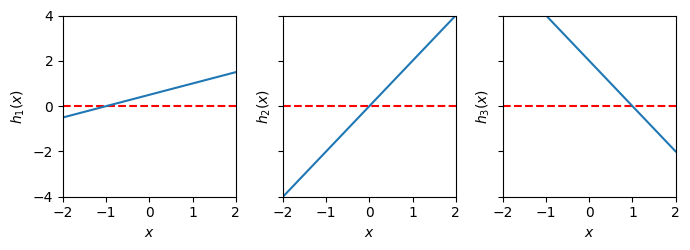

In [ ]:
# For input x, visualize any number on the real number line between -2 and 2
x = np.linspace(-2,2,num=201)

# For hidden neurons h1 - h3, start with a simple affine function for each.
h1 = 0.5 * x + 0.5
h2 =   2 * x
h3 =  -2 * x + 2

# Visualize the linear (affine) outputs of neurons h1 - h3, along with y=0
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(7,2.6))
for i, neuron in enumerate([h1, h2, h3]):
  axs[i].axhline(y=0, color='red', linestyle='--')
  axs[i].plot(x, neuron)
  axs[i].set_xlim(-2,2)
  axs[i].set_ylim(-4,4)
  axs[i].set_xlabel('$x$')
  axs[i].set_ylabel(f'$h_{i+1}(x)$')
plt.tight_layout()
plt.show()

We then apply the non-linear activation function, ReLU($h_{i}(x)$), and view these outputs.

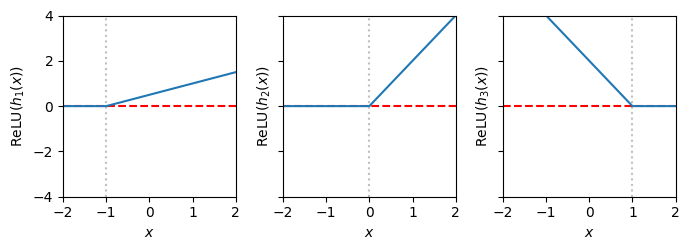

In [ ]:
# Next apply ReLU non-linearity
def ReLU(neuron):
  output = np.array([max(0, val) for val in neuron])
  nonlinearity = np.where(neuron==0)
  return output, nonlinearity

h1_relu = ReLU(h1)
h2_relu = ReLU(h2)
h3_relu = ReLU(h3)

# Visualize the non-linear outputs of neurons h1 - h3, along with their non-linearities and y=0
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(7,2.6))
for i, (neuron, nonlinearity) in enumerate([h1_relu, h2_relu, h3_relu]):
  axs[i].axvline(x=x[nonlinearity], color='grey', linestyle=':', alpha=0.5)
  axs[i].axhline(y=0, color='red', linestyle='--')
  axs[i].plot(x, neuron)
  axs[i].set_xlim(-2,2)
  axs[i].set_ylim(-4,4)
  axs[i].set_xlabel('$x$')
  axs[i].set_ylabel(f'ReLU($h_{i+1}(x)$)')
plt.tight_layout()
plt.show()

Finally, we calculate the output $z = \sum_{i}w_{i}$ReLU($h_{i}(x)$)$ + w_{b}$ as an affine combination of hidden neurons $\{h_{1}, h_{2}, h_{3}\}$ and a bias term $w_{b}$, and visualize all the steps together.

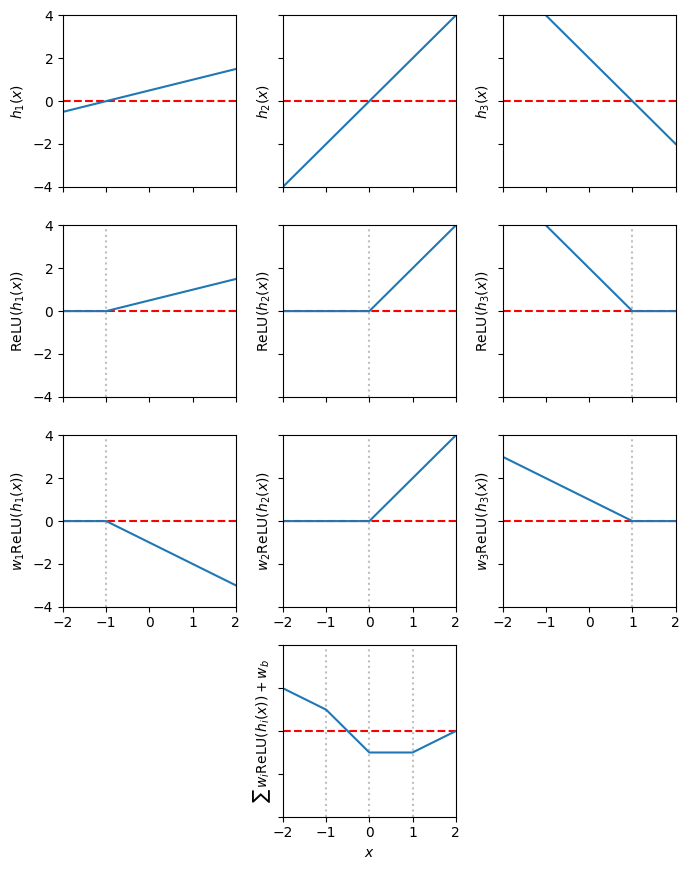

In [ ]:
# Calculate the linear transformation of each hidden neuron before summing to w
w1  = (  -2 * h1_relu[0], h1_relu[1])
w2  = (   1 * h2_relu[0], h2_relu[1])
w3  = ( 0.5 * h3_relu[0], h3_relu[1])

# Bias for final output z
w_b =  -1

# Calculate y as an affine combination of hidden neurons and bias
z = w1[0] + w2[0] + w3[0] + w_b

# Visualize all linear and non-linear functions adding up to output y
fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(7,8.8))
for j, neuron in enumerate([h1, h2, h3]):
  axs[0,j].axhline(y=0, color='red', linestyle='--')
  axs[0,j].plot(x,neuron)
  axs[0,j].set_xlim(-2,2)
  axs[0,j].set_ylim(-4,4)
  axs[0,j].set_ylabel(f'$h_{j+1}(x)$')
for j, (neuron, nonlinearity) in enumerate([h1_relu, h2_relu, h3_relu]):
  axs[1,j].axvline(x=x[nonlinearity], color='grey', linestyle=':', alpha=0.5)
  axs[1,j].axhline(y=0, color='red', linestyle='--')
  axs[1,j].plot(x, neuron)
  axs[1,j].set_ylabel(f'ReLU($h_{j+1}(x)$)')
for j, (neuron, nonlinearity) in enumerate([w1, w2, w3]):
  axs[2,j].axvline(x=x[nonlinearity], color='grey', linestyle=':', alpha=0.5)
  axs[2,j].axhline(y=0, color='red', linestyle='--')
  axs[2,j].plot(x, neuron)
  axs[2,j].set_ylabel(f'$w_{j+1}$ReLU($h_{j+1}(x)$)')
  axs[2,j].tick_params(axis='x', labelbottom=True)
  axs[3,1].axvline(x = x[nonlinearity], color='grey', linestyle=':', alpha=0.5)
axs[3,1].axhline(y=0, color='red', linestyle='--')
axs[3,1].plot(x, z)
axs[3,1].set_ylabel(r'$\sum \, w_{i}$ReLU($h_{i}(x))+w_{b}$')
axs[3,1].set_xlabel('$x$')
axs[3,0].axis('off')
axs[3,2].axis('off')

plt.tight_layout()
plt.show()

Note that the non-linearities introduced by ReLU in the three hidden neurons split the input space into four regions, $(x \leq -1)$, $(-1 < x \leq 0)$, $(0 < x \leq 1)$, and $(x > 1)$. Furthermore, within each of these regions, the output (y-axis) is a simple affine transformation of the input (x-axis).

  We can calculate these affine transformations as $z = \sum_{i} [w_{i} \, h_{i}(x) \, \mathbf{1}_{h_{i}(x)>0} ] + w_{b}$, where $w_{i}$ and $w_{b}$ are the slope and bias of the affine transformation from the hidden neuron $h_{i}$ to output $z$ ; $h_{i}(x) = a_{i}x + b_{i}$ is the affine transformation from the input $x$ to hidden neuron $h_{i}$ ; and $\mathbf{1}_{h_{i}(x)>0}$ is the indicator function equal to $1$ when $h_{i}(x) > 0$ and equal to $0$ otherwise. The result is a continuous, piecewise-affine function over the entire input space.

$$
z(x) =
\begin{cases}
    w_{3} h_{3}(x) + w_{b}, & \text{if } \;\; x \leq -1 \\
    w_{1} h_{1}(x) + w_{3} h_{3}(x) + w_{b}, & \text{if } \;\; -1 < x \leq 0 \\
    w_{1} h_{1}(x) + w_{2} h_{2}(x) + w_{3} h_{3}(x) + w_{b}, & \text{if } \;\; 0 < x \leq 1 \\
    w_{1} h_{1}(x) + w_{2} h_{2}(x) + w_{b}, & \text{if } \;\; x > 1
\end{cases}
$$

## 2D Deep Network

Here we show a slightly more complex MASO DN classifying two-dimensional points into one of two classes. The model has three hidden layers and a final linear classifier. The hidden layers are fully connected layers with 16, 8, and 4 neurons per layer, and the linear classifier is also fully connected with a single output. Below we show the partitions each layer draws on the two-dimensional input space and how these partitions change as the model trains.

Epoch    0   Loss:  724.45032
Epoch   10   Loss:    8.23753
Epoch  100   Loss:    0.04505


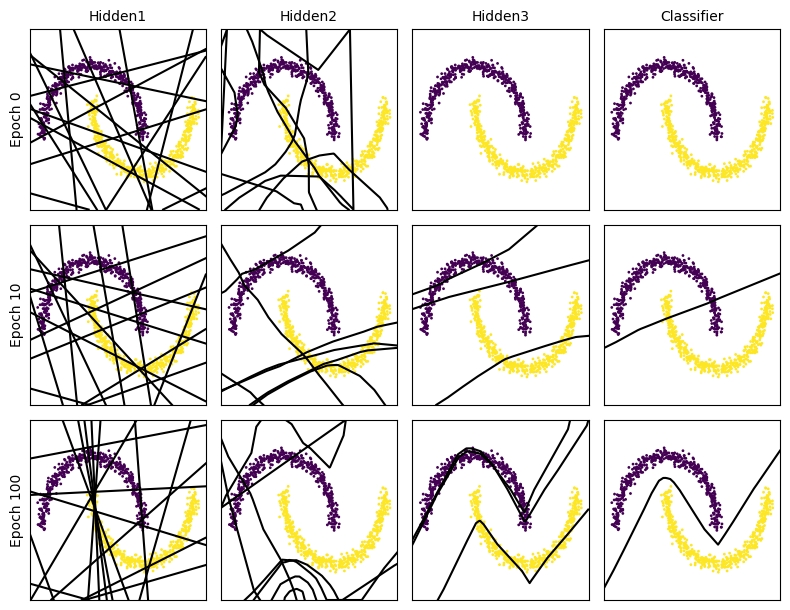

In [ ]:
# Define Simple Model with 3 Hidden Layers and ReLU activations
relu = torch.nn.ReLU()
linear1 = torch.nn.Linear(in_features=2, out_features=16)
linear2 = torch.nn.Linear(in_features=16, out_features=8)
linear3 = torch.nn.Linear(in_features=8, out_features=4)
linear4 = torch.nn.Linear(in_features=4, out_features=1)
layer_dict = OrderedDict([('Hidden1',linear1),
                      ('ReLU1',relu),
                      ('Hidden2',linear2),
                      ('ReLU2',relu),
                      ('Hidden3', linear3),
                      ('ReLU3', relu),
                      ('Classifier',linear4)])
model = torch.nn.Sequential(layer_dict)

# Generate toy dataset of 2D points arranged in two half-circles
class dataset(torch.utils.data.Dataset):
  def __init__(self, inputs, labels):
    super().__init__()
    self.inputs = inputs
    self.labels = labels
  def __len__(self):
    return len(self.inputs)
  def __getitem__(self, idx):
    return self.inputs[idx], self.labels[idx]

x,y = make_moons(n_samples=1000, shuffle=True, noise=0.05)
x,y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
data = dataset(x,y)
loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)

# Calculate loss on randomly initialized model
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')
with torch.no_grad():
  outputs = model(x)
  epoch_loss = loss_fn(outputs, y[:,None])
print(f'Epoch {0:>4}   Loss: {epoch_loss:>10.5f}')

# Store partitions on untrained model
partitions = dict()
partitions[0] = get_partitions(model, x_span=(-1.25, 2.25, 300), y_span=(-1, 1.5, 300))

# Train model on toy dataset
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean')
for epoch in range(100):
  epoch_loss = 0
  for batch in loader:
    inputs, labels = batch
    optimizer.zero_grad()
    outputs = model(inputs)
    batch_loss = loss_fn(outputs, labels[:,None])
    batch_loss.backward()
    optimizer.step()
    epoch_loss += batch_loss.item() * len(batch)

  # Print loss and store partitions for specific epochs
  if epoch+1 in {10,100}:
    print(f'Epoch {epoch+1:>4}   Loss: {epoch_loss:>10.5f}')
    partitions[epoch+1] = get_partitions(model, x_span=(-1.25, 2.25, 300), y_span=(-1, 1.5, 300))

# Show partitions across epochs
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(8,6.2), sharex=True, sharey=True)
axs[0,0].set_ylim((-1,1.5))
axs[0,0].set_xlim(-1.25,2.25)
for i, epoch in enumerate(partitions.keys()):
  axs[i,0].set_ylabel(f'Epoch {epoch}')
  for j, (layer, partition) in enumerate(partitions[epoch].items()):
    axs[0,j].set_title(layer, fontsize=10)
    axs[i,j].scatter(x[:,0],x[:,1],c=y, s=1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    for k in range(len(partition)):
      axs[i,j].plot(partition[k][:,0], partition[k][:,1], c='k')
plt.tight_layout()
plt.show()

It is hard to interpret the partitions of any individual layer except "Classifier", where the trained partition clearly separates the two classes, and possibly the final hidden layer, which when trained seems to roughly follow the two groups of data and predict the shape of the final decision boundary. And obviously none of the partitions past the first hidden layer form straight lines on the input space (they do form straight lines, planes, or hyperplanes on their own *layer* input spaces, but those layer input spaces are often in higher dimensions that we cannot visualize). However, when we overlay all of the layers' partitions on top of each other, we see a different interpretation of the entire network.

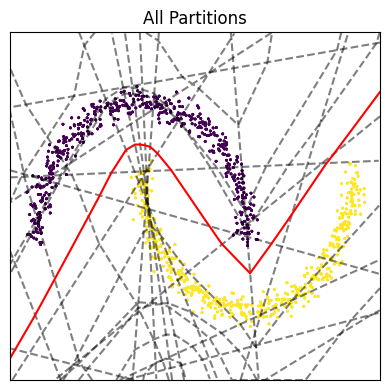

In [ ]:
epoch = 100
fig, axs = plt.subplots(figsize=(4,4))
for j, (layer, partition) in enumerate(partitions[epoch].items()):
  axs.set_title('All Partitions')
  axs.scatter(x[:,0],x[:,1],c=y, s=1)
  axs.set_xticks([])
  axs.set_yticks([])
  for k in range(len(partition)):
    if layer != 'Classifier':
      axs.plot(partition[k][:,0], partition[k][:,1], c='k', alpha=0.5, linestyle='--')
    else:
      axs.plot(partition[k][:,0], partition[k][:,1], c='r')
plt.tight_layout()
axs.set_ylim((-1,1.5))
axs.set_xlim(-1.25,2.25)
plt.show()

Looking at the superimposed partitions across all layers, we can see that, however non-linear some of them may appear, they are all in fact "piecewise-linear" in the sense that no partition deviates from a straight line except where it intersects with a break made by a previous partition, and this can be traced all the way back to the straight-line partitions of hidden layer 1. One interpretation then of some of the earlier, less interpretable partitions in early layers is that they provide "break points" for later layers, allowing partitions in those later layers to change direction.

Also, the regions defined by these partitions are all convex, and the mapping from input to output within each convex region is again a simple affine transformation. We can therefore move some of our attention from the partitions themselves to the regions they create, regions within which any input will be subject to the same affine transformation. One thing to note is that not all data points from the same class fall within the same region, though often (not always) you will find singular regions that encompass a large number of data points from the same class.

So long as certain conditions are met, a large class of deep neural networks (including feedforward neural networks, convolutional neural networks, and recurrent neural networks) can be broken down in this way, regardless of the number of inputs, outputs, and hidden layers. See Balestriero & Baraniuk (2018a, 2018b) for a description of these conditions and a fuller list of DNs that meet them, and Prince (2023, chapters 3 & 4) for more illustrations and interactive figures like the ones above. Also note that the visualizations above are generated using a uniform sampling of points across the input space--for an analytical method of finding and visualizing a DN's partitions, see Humayun et al. (2023).

## Characteristics of MASO DNs

This formulation of deep neural networks gives us new insights into their training and inference. The two we will be focusing on in this notebook are:

1.   MASO DNs construct "a set of signal-dependent, class-specific templates against which the signal is compared via a simple inner product" (Balestriero & Baraniuk, 2018b);
2.   local complexity, i.e. the concentration of partitions near data points, can be used as a progress measure of generalization and robustness and is connected to grokking (Humayun et al., 2024).

## Signal-dependent, class-specific templates

Balestriero & Baraniuk (2018a, 2018b) generalize and collapse the above piecewise function into a single equation for DNs,

$z^{(L)}(x) = W^{(L)}(A[x]x + B[x]) + b^{(L)}_{W}$

where $z^{(L)}(x)$ is the output at the $L^{th}$ (i.e. final) layer ; $W^{(L)}$ and $b^{(L)}_{W}$ are the weights and biases of the final linear classifier ; and $A[x]x$ and $B[x]$ are the weights and biases of the input-specific affine transformation composed of all layers between the input and final linear classifier.

Rearranging the terms and removing the superscript $(L)$ for readability, we can rewrite the above equation as

$z(x) = (WA[x])\;x + (WB[x] + b_{W})$

which "provides the alternate interpretation that $z^{(L)}(x)$ is the output of a bank of *linear matched filters* (plus a set of biases)" (Balestriero & Baraniuk, 2018b). That is, the rows of the matrix $(WA[x]) \in R^{C\times D}$, where $C$ is the number of classes and $D$ is the dimension of the input, are signal-dependent, class-specific templates, and we can classify the input $x$ by taking its inner product with each template and selecting the index of the highest value (after adding in the bias terms).

### Collinear Templates and Data Set Memorization

First we will look at the *ideal* templates for a normalized input $x$ with cross entropy loss and the additional constraint that the sum of L2 template norms is less than some value $a$ where $a > 0$ (Balestriero & Baraniuk, 2018b, Proposition 5.5). In this case, the idealized templates for an input $x$ are

$$
(WA[x])^{\star}_{c} =
\begin{cases}
    +\sqrt{\frac{(C-1)a}{C}}x, & c=y \\
    -\sqrt{\frac{a}{C(C-1)}}x, & c\neq y \\
\end{cases}
$$

i.e. they are scaled copies of the input $x$. Specifically, for the positive class, the template is a vector in the same direction as $x$, scaled by the square root of $a(C-1)/C$; while the template for *all negative classes* is a vector in the opposite direction, scaled by the negative square root of $a/C(C-1)$. See Balestriero & Baraniuk (2018b, Appendix D.5) for the proof of these templates' optimality. In the code below we set $a = 1$.

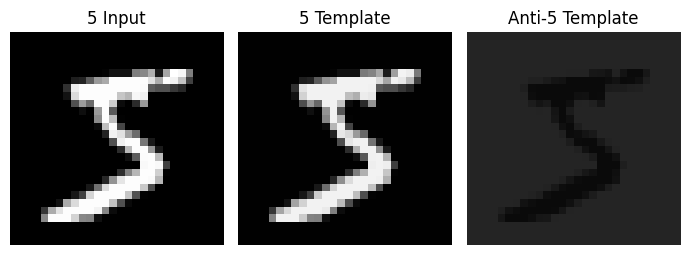


Class    Inner Product    Probability
[0]            -0.1054          8.43%
[1]            -0.1054          8.43%
[2]            -0.1054          8.43%
[3]            -0.1054          8.43%
[4]            -0.1054          8.43%
[5]             0.9487         24.17%
[6]            -0.1054          8.43%
[7]            -0.1054          8.43%
[8]            -0.1054          8.43%
[9]            -0.1054          8.43%


Cosine similarity matrix of templates
tensor([[ 1.00,  1.00,  1.00,  1.00,  1.00, -1.00,  1.00,  1.00,  1.00,  1.00],
        [ 1.00,  1.00,  1.00,  1.00,  1.00, -1.00,  1.00,  1.00,  1.00,  1.00],
        [ 1.00,  1.00,  1.00,  1.00,  1.00, -1.00,  1.00,  1.00,  1.00,  1.00],
        [ 1.00,  1.00,  1.00,  1.00,  1.00, -1.00,  1.00,  1.00,  1.00,  1.00],
        [ 1.00,  1.00,  1.00,  1.00,  1.00, -1.00,  1.00,  1.00,  1.00,  1.00],
        [-1.00, -1.00, -1.00, -1.00, -1.00,  1.00, -1.00, -1.00, -1.00, -1.00],
        [ 1.00,  1.00,  1.00,  1.00,  1.00, -1.00,  1.00,  1.

In [ ]:
# Use MNIST "5" as input
input = mnist[0][0][0]
label = mnist[0][1]

# Normalize input so norm = 1
input = input / torch.linalg.matrix_norm(input)

# Flatten input for template
flat_input = input.flatten()

# Calculate templates with C = 10 and a = 10
C = 10
a=1
right_template = math.sqrt((C-1)*a/C) * flat_input
wrong_template = -math.sqrt(a/(C*(C-1))) * flat_input

# Put templates into C x D matrix
templates = torch.stack([wrong_template]*C)
templates[label] = right_template

# Calculate inner product of all templates and input
outputs = torch.matmul(templates, flat_input)

# Calculate probabilities for each class using softmax over inner products
probs = torch.nn.functional.softmax(outputs, dim=0)

# Visualize input and templates
vmax = max(input.max(), templates.max())
vmin = min(input.min(), templates.min())
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7,2.5))
axs[0].imshow(input, cmap='grey', vmax=vmax, vmin=vmin)
axs[1].imshow(right_template.view(28,28), cmap='grey', vmax=vmax, vmin=vmin)
axs[2].imshow(wrong_template.view(28,28), cmap='grey', vmax=vmax, vmin=vmin)
axs[0].set_title(f'{label} Input')
axs[1].set_title(f'{label} Template')
axs[2].set_title(f'Anti-{label} Template')
for i in range(3):
  axs[i].axis('off')
plt.tight_layout()
plt.show()
print()

# Print the inner products and probabilities for each class
print('Class    Inner Product    Probability')
for i in range(10):
  print(f'[{i}]    {outputs[i]:>15.4f}       {probs[i]:>8.2%}')
print()
print()

# Calculate cosine similarity of templates
angles = torch.nn.functional.normalize(templates, dim=1)
angles = torch.matmul(angles, angles.T)
torch.set_printoptions(precision=2, sci_mode=False)
print('Cosine similarity matrix of templates')
print(angles)
torch.set_printoptions(profile='default')

In the visualizations above, note that the class template, i.e. the template specific to the class the input belongs to, is in fact a scaled version (scaled in pixel intensity, not in size) of the input itself. Although harder to see, the "anti-template", i.e. the template for any class other than the one the input belongs to, is a negative scaling of the input, where values corresponding to the higher (brighter) values in the input are lower (darker) in the anti-template. Scaling $a > 1$ will exagerate these differences, and thus also push the inner products and probabilities of the correct and incorrect classes further apart.

Because the ideal templates are scaled copies of the input, one positive and one negative, it comes as no surprise that all templates are collinear and have a cosine similarity with each other of either 1 or -1 depending on their classes.

### Orthogonal Templates

"While a DN’s signal-dependent matched filterbank is optimized for classifying signals immersed in additive white Gaussian noise, such a statistical model is overly simplistic for most machine learning problems of interest. In practice, errors will arise not just from noise but also from nuisance variations in the inputs, such as arbitrary object rotations and positions, occlusions, lighting conditions, etc. The effects of these nuisances are only poorly approximated as Gaussian random noise." (Balestriero & Baraniuk, 2018b).

The authors point out that there is a dearth of research on filterbanks used for classification in non-Gaussian noise, but find a promising avenue with orthogonal templates. They introduce a penalty term that induces orthogonality in the linear classifier's weights and show through experimentation that it improves performance and reduces overfitting.

Playing with this idea, we keep the same ideal template for the correct class, but then force all the other templates to be orthogonal to it and each other. We then measure and visualize these templates as above.

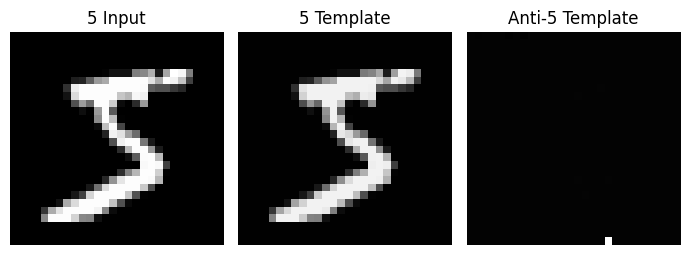


Class    Inner Product    Probability
[0]            -0.0000          8.63%
[1]            -0.0000          8.63%
[2]            -0.0000          8.63%
[3]            -0.0000          8.63%
[4]            -0.0000          8.63%
[5]             0.9487         22.30%
[6]            -0.0000          8.63%
[7]            -0.0000          8.63%
[8]            -0.0000          8.63%
[9]            -0.0000          8.63%


Cosine similarity matrix of templates
tensor([[ 1.00,  0.00,  0.00,  0.00,  0.00, -0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  1.00,  0.00,  0.00,  0.00, -0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  1.00,  0.00,  0.00, -0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  1.00,  0.00, -0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  1.00, -0.00,  0.00,  0.00,  0.00,  0.00],
        [-0.00, -0.00, -0.00, -0.00, -0.00,  1.00, -0.00, -0.00, -0.00, -0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00, -0.00,  1.00,  0.

In [ ]:
# Force all wrong templates to be orthogonal to right template (and each other)
Q, R = torch.linalg.qr(templates.T, mode='complete')
ortho_templates = Q.T[-10:]
ortho_templates[label] = right_template

# Calculate inner product of all templates and input
outputs = torch.matmul(ortho_templates, flat_input)

# Calculate probabilities for each class using softmax over inner products
probs = torch.nn.functional.softmax(outputs, dim=0)

# Visualize input and templates (we don't scale by ortho_templates because they
# have significantly larger range than the normalized input or right_template)
vmax = max(input.max(), right_template.max())
vmin = min(input.min(), right_template.min())
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7,2.5))
axs[0].imshow(input, cmap='grey', vmax=vmax, vmin=vmin)
axs[1].imshow(ortho_templates[label].view(28,28), cmap='grey', vmax=vmax, vmin=vmin)
axs[2].imshow(ortho_templates[0 if 0!= label else 1].view(28,28), cmap='grey')
axs[0].set_title(f'{label} Input')
axs[1].set_title(f'{label} Template')
axs[2].set_title(f'Anti-{label} Template')
for i in range(3):
  axs[i].axis('off')
plt.tight_layout()
plt.show()
print()

# Print the inner products and probabilities for each class
print('Class    Inner Product    Probability')
for i in range(10):
  print(f'[{i}]    {outputs[i]:>15.4f}       {probs[i]:>8.2%}')
print()
print()

# Calculate cosine similarity of templates
angles = torch.nn.functional.normalize(ortho_templates, dim=1)
angles = torch.matmul(angles, angles.T)
torch.set_printoptions(precision=2, sci_mode=False)
print('Cosine similarity matrix of templates')
print(angles)
torch.set_printoptions(profile='default')

As we can see, the inner products and probabilities are similarly distributed, with the difference that the wrong templates have an inner product of 0 with the input rather than a negative value. The orthogonal "anti-template" no longer has any visual similarity to the input, just forming a random vector (one of many possible) that has an inner product of 0 with the input. And the cosine similarity matrix, as we would expect for orthogonal vectors, is 1 along the diagonal and 0 everywhere else.

## Local Complexity

Local complexity is a progress measure that quantifies the concentration of partitions / non-linearities near data points. It does this by defining a convex hull around individual data points and counting how many partitions intersect each hull, then taking the mean across data points. This is important because, as explained above, each region defined by these partitions represents a different affine transformation; therefore a higher concentration of partitions near data points indicates a higher number of possible affine transformations, possibly resulting in different outputs for similar inputs. By contrast, a lower concentration indicates the same linear regions around similar inputs, which previous studies have connected with both generalization and robustness.

The figure below shows the local complexity for both our trained model from the start of this notebook and a manually-set model using the fewest partitions possible. You can see visually that there are far fewer partitions intersecting the data (as well as far fewer partitions in general) in the manual model, resulting in a much lower local complexity.

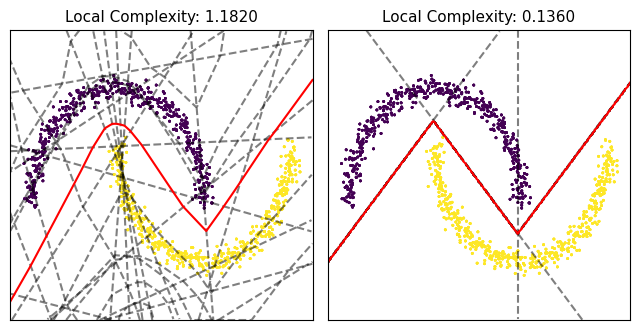

In [ ]:
fixed_relu = torch.nn.ReLU()
fixed_linear1 = torch.nn.Linear(in_features=2, out_features=16)
fixed_linear2 = torch.nn.Linear(in_features=16, out_features=8)
fixed_linear3 = torch.nn.Linear(in_features=8, out_features=4)
fixed_linear4 = torch.nn.Linear(in_features=4, out_features=1)
fixed_layer_dict = OrderedDict([('Hidden1',fixed_linear1),
                      ('ReLU1',fixed_relu),
                      ('Hidden2',fixed_linear2),
                      ('ReLU2',fixed_relu),
                      ('Hidden3', fixed_linear3),
                      ('ReLU3', fixed_relu),
                      ('Classifier',fixed_linear4)])
fixed_model = torch.nn.Sequential(fixed_layer_dict)

hidden1_weights = torch.zeros((16,2))
hidden1_weights[:3] = torch.tensor([[-1., 1.],
                                    [ 1., 1.],
                                    [ 2., 0.]])
hidden1_bias = torch.zeros(16)
hidden1_bias[:3] = torch.tensor([-0.75,-0.7,-1.9])
hidden2_weights = torch.zeros((8,16))
hidden2_weights[:1,:3] = torch.tensor([[1.,1.,-1.]])
hidden2_bias = torch.zeros(8)
hidden3_weights = torch.zeros((1,8))
hidden3_weights[0,0] = torch.tensor([1.])
hidden3_bias = torch.zeros(4)
classifier_weights = torch.zeros((1,4))
classifier_weights[0,0] = torch.tensor([1.])
classifier_bias = torch.zeros(1)

with torch.no_grad():
  fixed_model.Hidden1.weight.copy_(hidden1_weights)
  fixed_model.Hidden1.bias.copy_(hidden1_bias)
  fixed_model.Hidden2.weight.copy_(hidden2_weights)
  fixed_model.Hidden2.bias.copy_(hidden2_bias)
  fixed_model.Hidden3.weight.copy_(hidden3_weights)
  fixed_model.Hidden3.bias.copy_(hidden3_bias)
  fixed_model.Classifier.weight.copy_(classifier_weights)
  fixed_model.Classifier.bias.copy_(classifier_bias)

complexity = [get_local_complexity(model, loader, radius=0.05, seed=0), get_local_complexity(fixed_model, loader, radius=0.05, seed=0)]
fixed_partitions = get_partitions(fixed_model, x_span=(-1.25, 2.25, 300), y_span=(-1, 1.5, 300))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6.5,3.4))
for i, parts in enumerate([partitions[100], fixed_partitions]):
  for j, (layer, partition) in enumerate(parts.items()):
    axs[i].set_title(f'Local Complexity: {complexity[i]['Total']['Complexity']:.4f}', fontsize=11)
    axs[i].scatter(x[:,0],x[:,1],c=y, s=1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_ylim((-1,1.5))
    axs[i].set_xlim(-1.25,2.25)
    for k in range(len(partition)):
      if layer != 'Classifier':
        axs[i].plot(partition[k][:,0], partition[k][:,1], c='k', alpha=0.5, linestyle='--')
      else:
        axs[i].plot(partition[k][:,0], partition[k][:,1], c='r')
plt.tight_layout()
plt.show()

We can also look at the local complexity and eccentricity of individual layers. The eccentricity measures how much later layers distort the (originally regular) convex hulls around data points, which might affect the number of intersections with that layer's partitions. If the eccentricity grows too large, we can decrease the radius of the convex hulls, which decreases their eccentricity in later layers. Total eccentricity is measured as the maximum eccentricity across all layers.

In [12]:
print('Trained Model')
print()
lc = get_local_complexity(model, loader, radius=0.05, seed=0)
for key in lc:
  if key == 'Total':
    print()
  print(f'{key:<10}   Complexity: {lc[key]["Complexity"]:.4f}    Eccentricity: {lc[key]["Eccentricity"]:.4f}')

Trained Model

Hidden1      Complexity: 0.7160    Eccentricity: 0.2542
Hidden2      Complexity: 0.0520    Eccentricity: 0.2219
Hidden3      Complexity: 0.4140    Eccentricity: 0.6358
Classifier   Complexity: 0.0000    Eccentricity: 1.5072

Total        Complexity: 1.1820    Eccentricity: 1.5072


In [13]:
print('Fixed Model')
print()
lc = get_local_complexity(fixed_model, loader, radius=0.05, seed=0)
for key in lc:
  if key == 'Total':
    print()
  print(f'{key:<10}   Complexity: {lc[key]["Complexity"]:.4f}    Eccentricity: {lc[key]["Eccentricity"]:.4f}')

Fixed Model

Hidden1      Complexity: 0.1130    Eccentricity: 0.2271
Hidden2      Complexity: 0.0180    Eccentricity: 0.1021
Hidden3      Complexity: 0.0040    Eccentricity: 0.1343
Classifier   Complexity: 0.0010    Eccentricity: 0.0671

Total        Complexity: 0.1360    Eccentricity: 0.2271


In "Deep Networks Always Grok and Here is Why" (Humayun et al., 2024), the authors introduce local complexity as a progress measure and identify a double descent behavior during training where the local complexity decreases, increases, then decreases again. The second descent coincides with a realignment of partitions away from training data points and towards the final decision boundaries, a phenomenon dubbed "region migration". The authors posit this as a causitive mechanism in *delayed generalization* and/or *delayed robustness*, or grokking. "Grokking occurs post phase transition as a robust partition of the input space thanks to the linearization of the DNN mapping around the training points" (Humayun et al., 2024).

# References

Balestriero, R., & Baraniuk, R. A Spline Theory of Deep Networks. In Proc. ICML, 2018a.

Balestriero, R., & Baraniuk, R. Mad Max: Affine Spline Insights into Deep Learning. arXiv preprint, arXiv:1805.06576v5, 2018b.

Prince, S. J. D. Understanding Deep Learning. MIT Press, 2023. http://udlbook.com

Humayun, A. I., Balestriero, R., Balakrishnan, G., & Baraniuk, R. SplineCam: Exact Visualization and Characterization of Deep Network Geometry and Decision Boundaries. In Proc. CVPR, 2023.

Humayun, A. I., Balestriero, R., & Baraniuk, R. Deep Networks Always Grok and Here is Why. In HiLD at ICML, 2024.